# Group 43 Project Proposal

### Predictors of Student Performance in School

For students, juggling high grades and a social life can be a stressful endeavor. Oftentimes students can overstudy for exams in order to achieve their desired grade. This leads to unneeded sacrifices being made in the other facets of a student's life. Performance in school often feels like a guessing game of whether you have put enough time into learning. Because of this, our group has decided to investigate what and how factors affect the performance of students in school (probably make more specific). We are trying to answer the question: what factors affect school performance the most (don't really know the question)? The data set we used is "Students Performance Data Set" compiled by Paulo Cortez, a professor at the Unversity of Minho in Portugal. This data set contains attributes about academic achievement, demographics, and the social and academic environment of a Portuguese language course, collected by survey in 2 Portuguese Secondary schools. 

### Preliminary Data Analysis

In [2]:
# Required libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [14]:
# Reading the data set from the web into R
student_data <- read_delim("https://raw.githubusercontent.com/gpark8910/DSCI100_project/main/student-por.csv",
                          delim = ";") %>%
    select(traveltime, studytime, freetime, goout, G1, G2, G3) %>% 
    mutate(G3 = case_when(
       G3 <= 9 ~ "fail",
       G3 >= 10 ~ "pass"))
student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



traveltime,studytime,freetime,goout,G1,G2,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,2,3,4,0,11,pass
1,2,3,3,9,11,pass
1,2,3,2,12,13,pass
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,2,1,1,11,12,fail
2,1,4,5,10,10,pass
3,1,4,1,10,11,pass


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



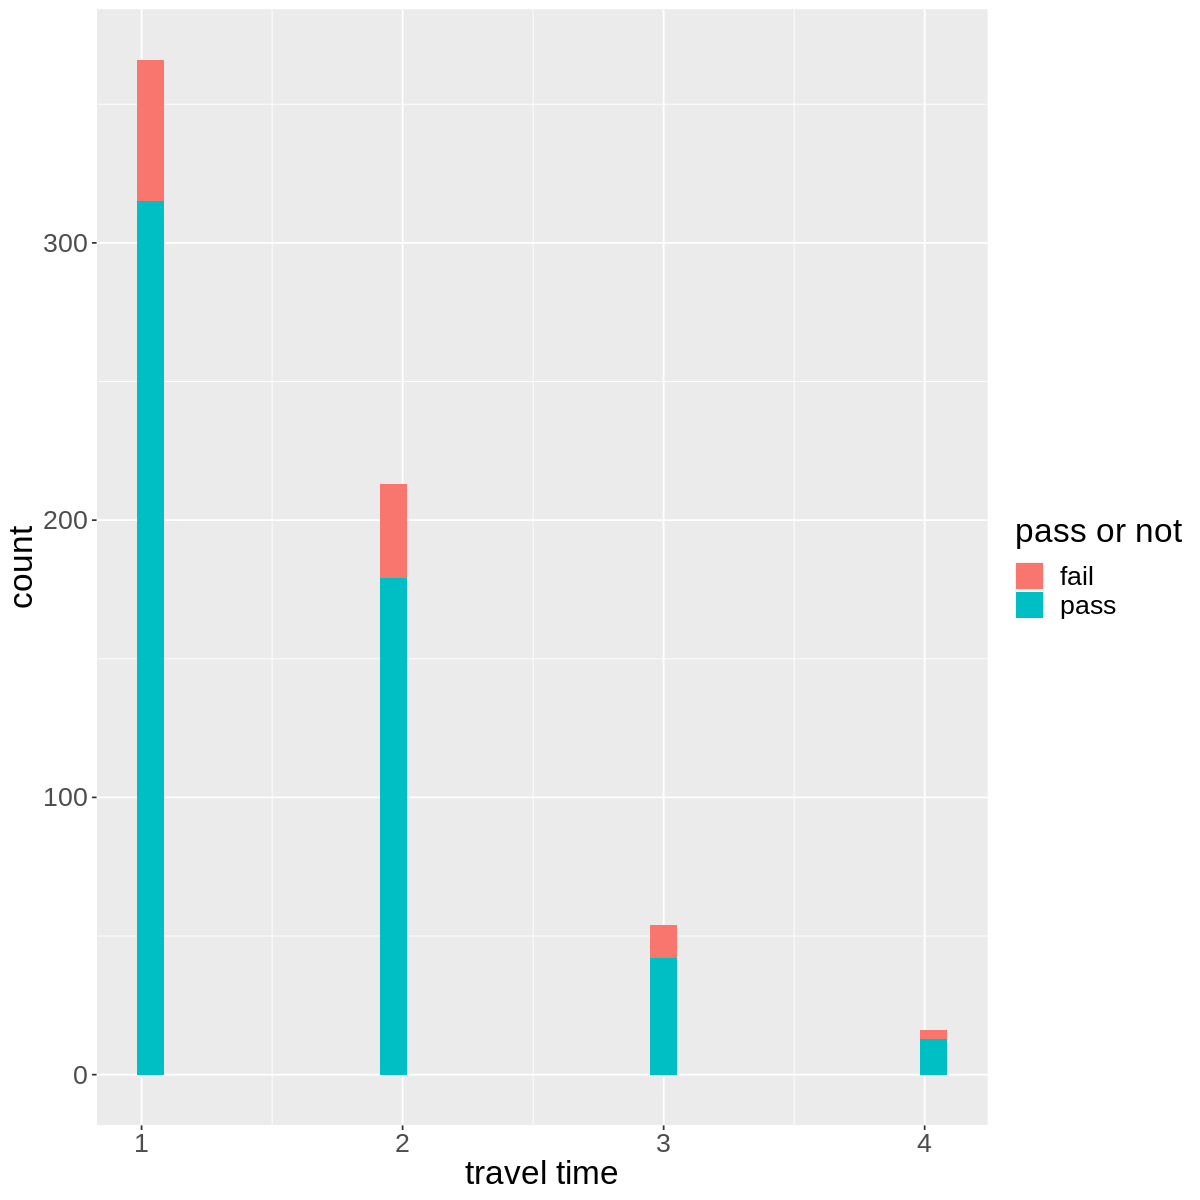

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



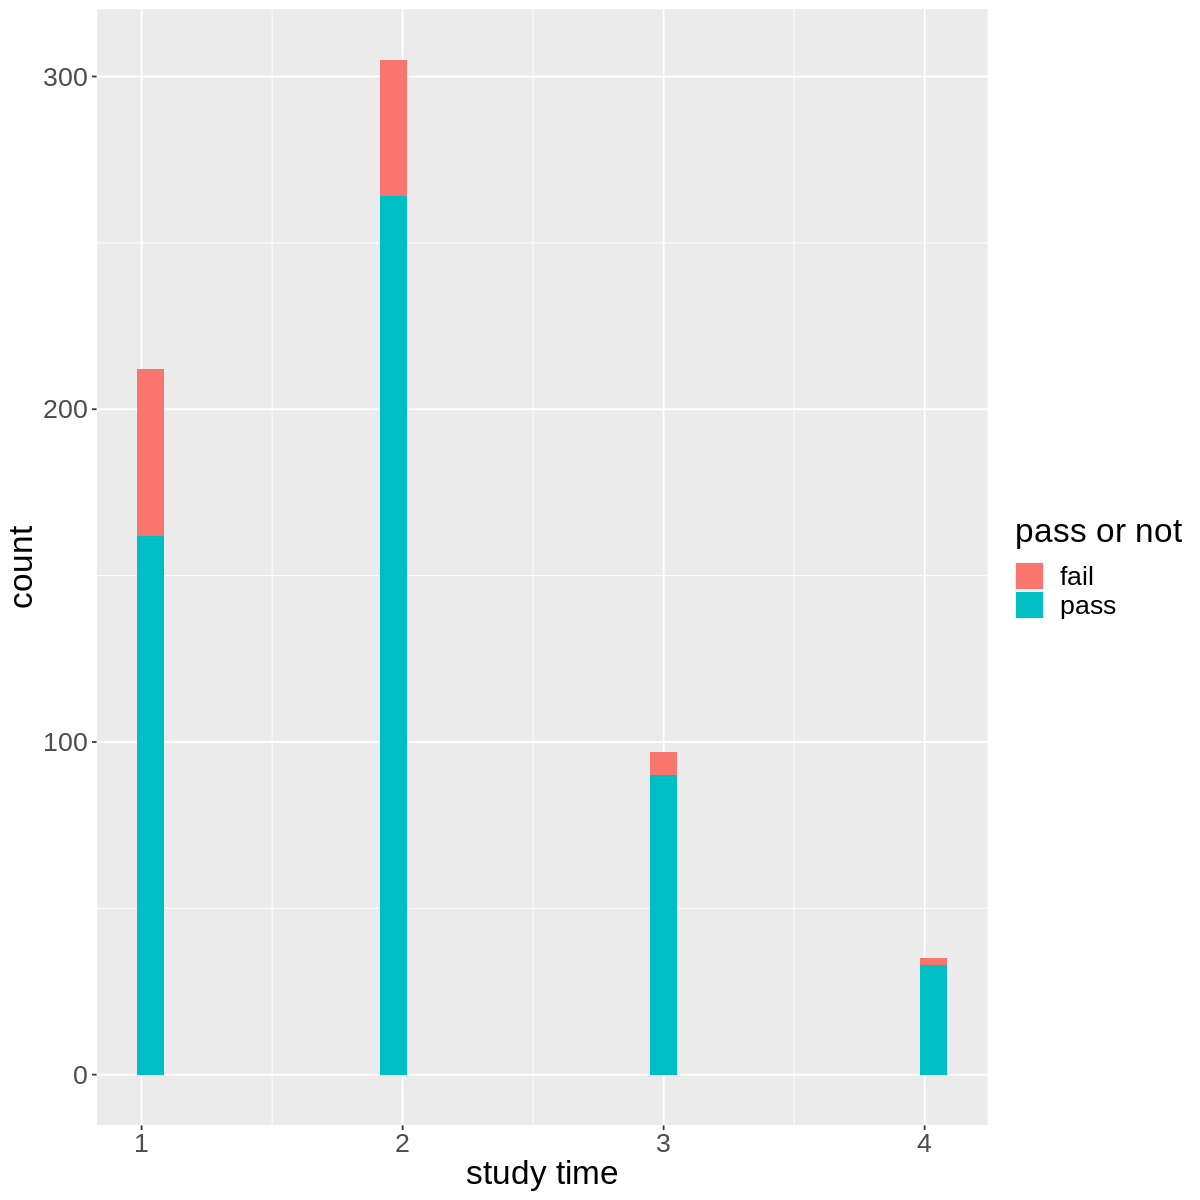

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



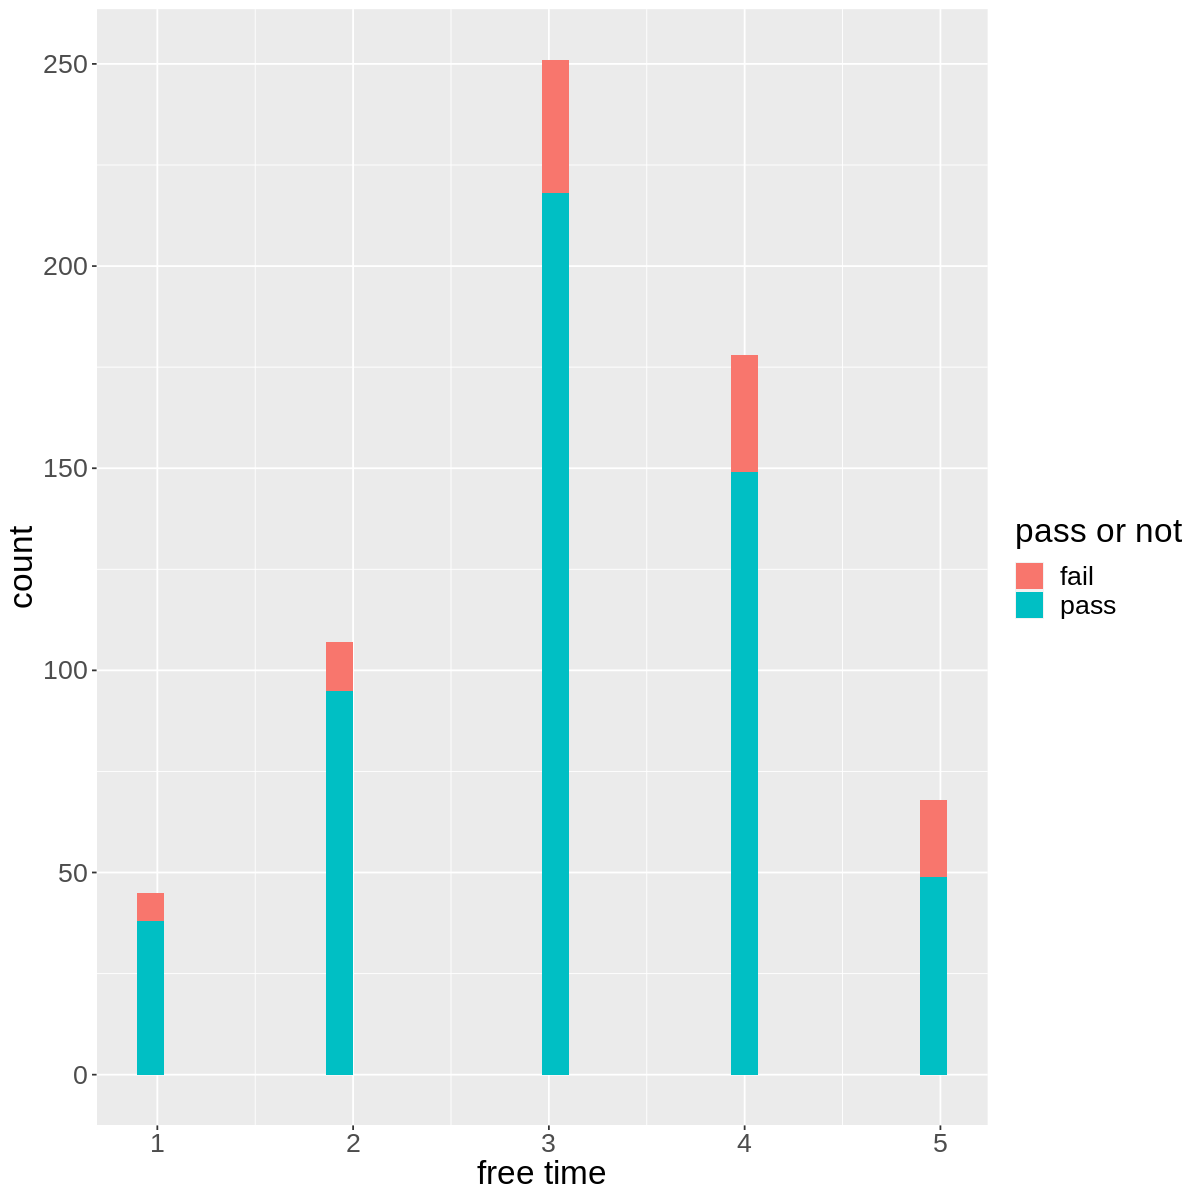

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



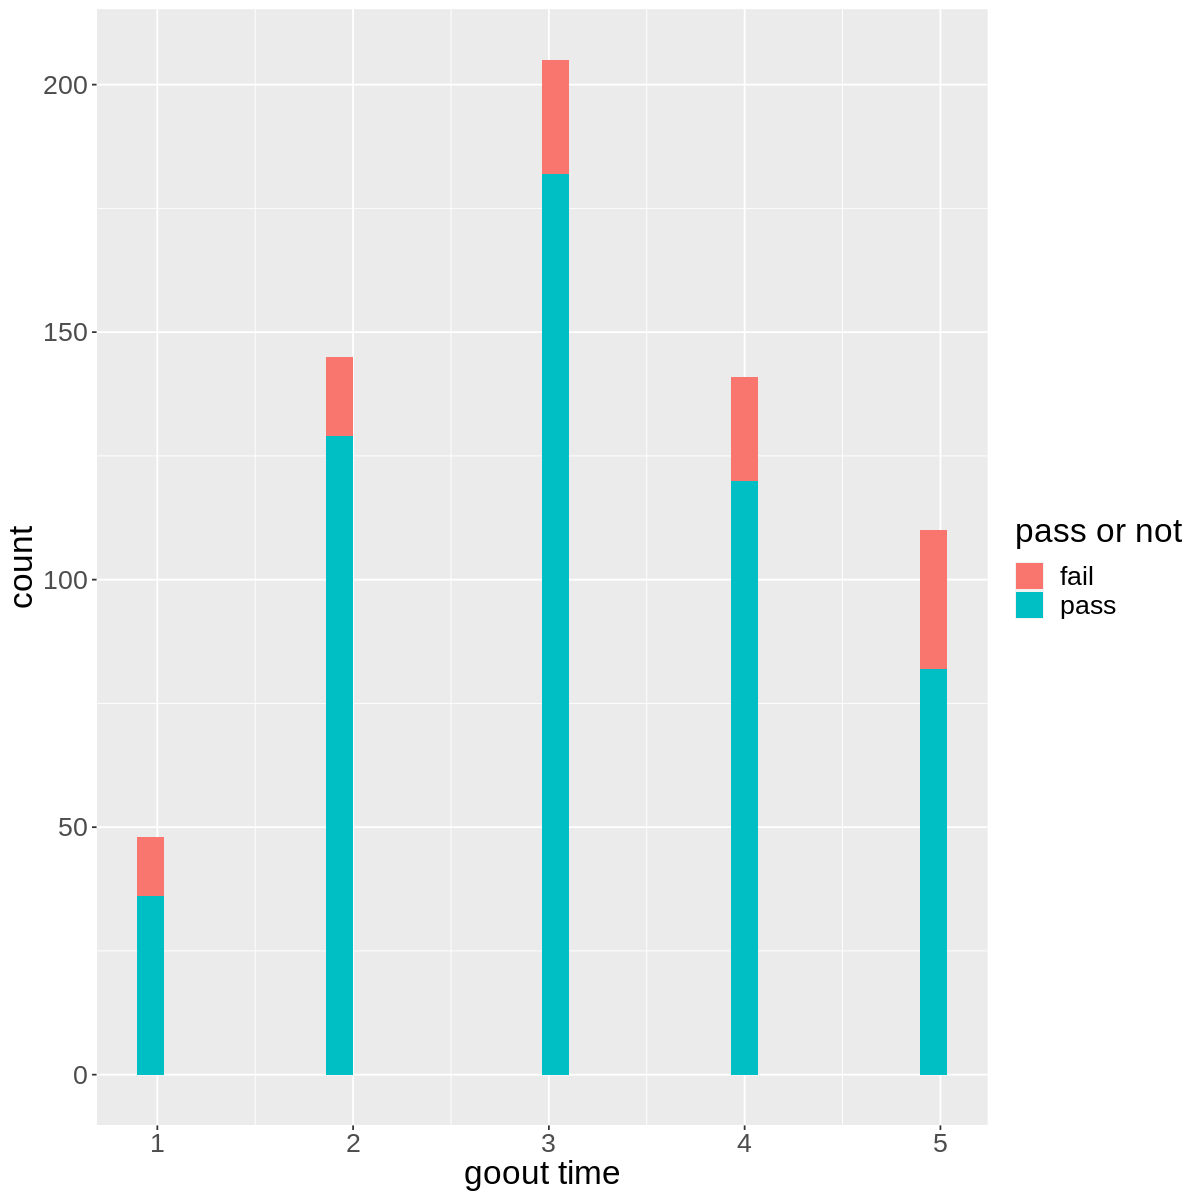

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



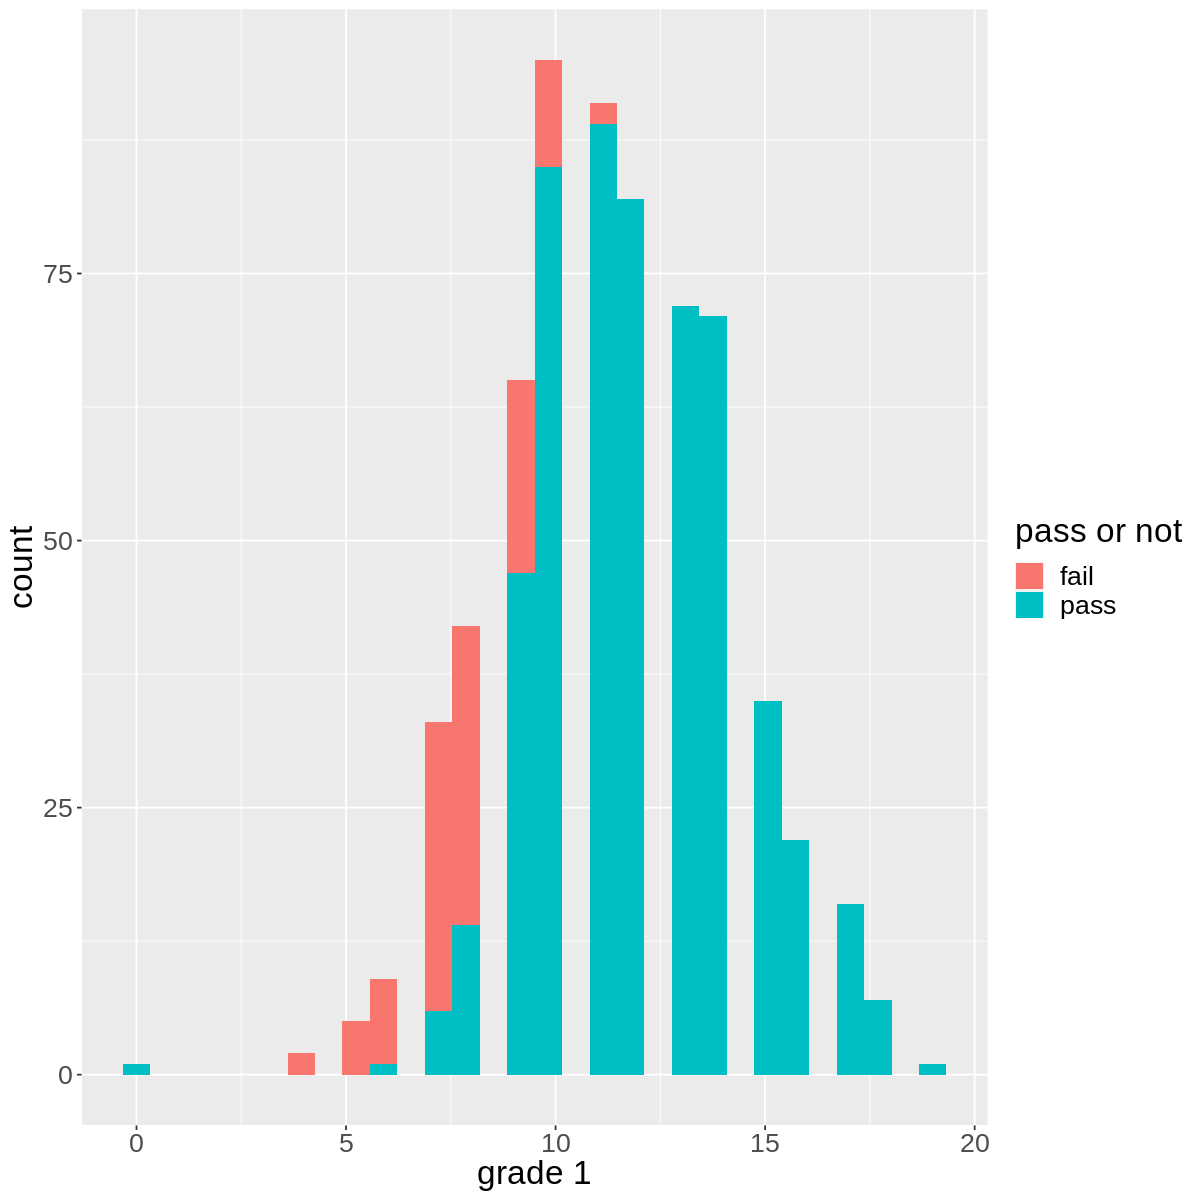

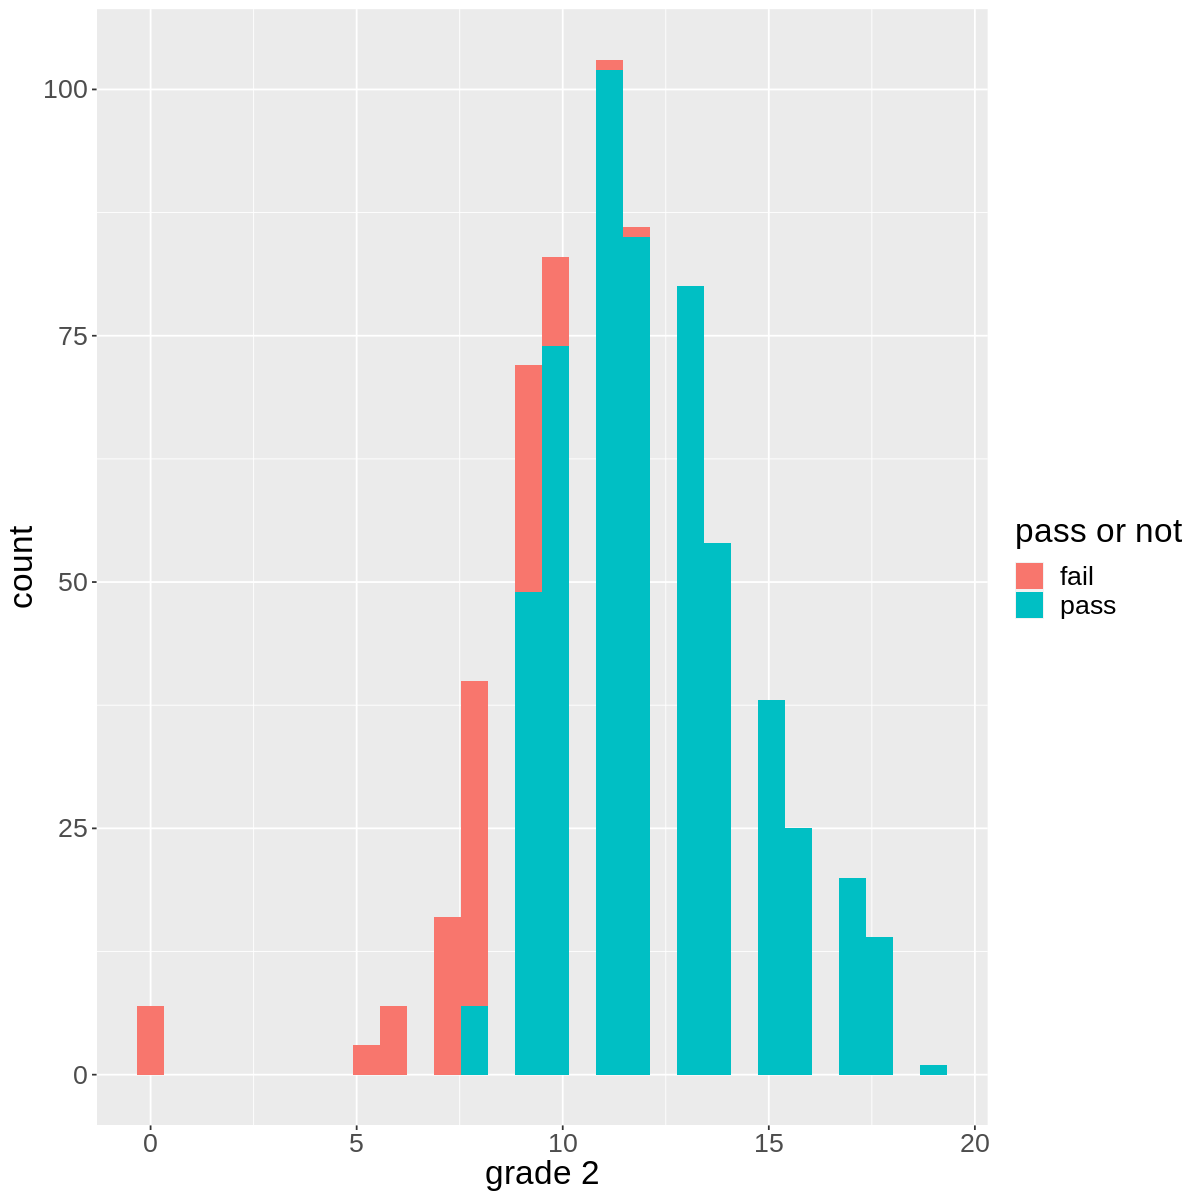

In [34]:
#create visualization for the data
options(repr.plot.width = 10, repr.plot.height = 10) 

travel_time_distribution <- student_data %>% 
   ggplot(aes(x = traveltime, fill = G3)) +
   geom_histogram() +
   labs(x = "travel time", fill = "pass or not") +
   theme(text = element_text(size = 20))

travel_time_distribution

study_time_distribution <- student_data %>% 
   ggplot(aes(x = studytime, fill = G3)) +
   geom_histogram() +
   labs(x = "study time", fill = "pass or not") +
   theme(text = element_text(size = 20))

study_time_distribution

free_time_distribution <- student_data %>% 
   ggplot(aes(x = freetime, fill = G3)) +
   geom_histogram() +
   labs(x = "free time", fill = "pass or not") +
   theme(text = element_text(size = 20))

free_time_distribution

goout_time_distribution <- student_data %>% 
   ggplot(aes(x = goout, fill = G3)) +
   geom_histogram() +
   labs(x = "goout time", fill = "pass or not") +
   theme(text = element_text(size = 20))

goout_time_distribution

grade_1_distribution <- student_data %>% 
   ggplot(aes(x = G1, fill = G3)) +
   geom_histogram() +
   labs(x = "grade 1", fill = "pass or not") +
   theme(text = element_text(size = 20))

grade_1_distribution

grade_2_distribution <- student_data %>% 
   ggplot(aes(x = G2, fill = G3)) +
   geom_histogram() +
   labs(x = "grade 2", fill = "pass or not") +
   theme(text = element_text(size = 20))

grade_2_distribution

In [ ]:
Methods: we will only use six column(traveltime, studytime, freetime, goout, G1, G2) as predictors to predict G3 column which is the final grades. 
And we reclassify G3 column where 0 ~ 9 means "fail" and 10 ~ 20 means "pass".